#**Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

In [6]:
!pip install -r /content/drive/MyDrive/Colab\ Notebooks/aml2024-students-copy/Crop-Yield-ML/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 60.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 49.5 MB/s e

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import sys

sys.path.append('/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/data')
data_path = '/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/data/full_data.csv'
fips_path = '/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/data/fips2county.tsv'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/pytorch-softdtw-cuda/')
image_path = '/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/'
processed_data_path='/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/data/processed_data'
%pylab inline

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from soft_dtw_cuda import SoftDTW
from math import sqrt
import collections
import os
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#**Preprocessing**

In [2]:
def breakup_timeseries(data):
    ts = []
    data = data[(data["County"] != "OTHER COUNTIES") & (data["County"] != "OTHER (COMBINED) COUNTIES")]
    data.set_index('Year', inplace=True)
    pairs = data[['State', 'County']].drop_duplicates().values.tolist()

    for p in pairs:
        state = p[0]
        county = p[1]
        ts.append(data[(data['State'] == state) & (data['County'] == county)])
    return ts

In [3]:
def interpolate_data(data):
    series_lengths = [len(series) for series in data]
    problems_index = []
    max_len = max(series_lengths)
    longest_series = None
    for series in data:
        if len(series) == max_len:
            longest_series = series

    for i in range(len(data)):
        if len(data[i])!= max_len:
            problems_index.append(i)
            data[i] = data[i].reindex(longest_series.index)

    for i in problems_index:
        data[i].interpolate(limit_direction="both",inplace=True)

    for i in range(len(data)):
        data[i].reset_index(inplace=True)
        data[i].fillna(method='bfill', inplace=True)
        data[i].fillna(method='ffill', inplace=True)
        data[i].fillna(method='backfill', inplace=True)

    return data


In [4]:
def preprocess(data):
    print('splitting data...')
    series = breakup_timeseries(data)
    print('interpolating data...')
    return interpolate_data(data=series)

In [5]:
def process_data():
  data = pd.read_csv(data_path)
  processed_data = preprocess(data)
  return processed_data

In [6]:
processed_data = process_data()
print('number of series: ', len(processed_data))
print(processed_data[0].head())

splitting data...
interpolating data...
number of series:  2810
   Year    State   County  CORN, GRAIN - YIELD, MEASURED IN BU / ACRE
0  1941  ALABAMA  AUTAUGA                                        10.0
1  1942  ALABAMA  AUTAUGA                                        14.0
2  1943  ALABAMA  AUTAUGA                                        14.0
3  1944  ALABAMA  AUTAUGA                                        13.0
4  1945  ALABAMA  AUTAUGA                                        12.0


In [7]:
mapping = {}
test_ind = 0
for df in processed_data:
  pair = df[["State", "County"]].drop_duplicates().values.tolist()[0]
  if test_ind == 0:
    print(pair)
  value = df[["CORN, GRAIN - YIELD, MEASURED IN BU / ACRE"]].values
  mapping[(pair[0], pair[1])] = value.reshape(value.shape[0],)
  test_ind+=1

# convert to tensor
tensor_array = torch.tensor([mapping[key] for key in mapping.keys()])
print(tensor_array.shape)

['ALABAMA', 'AUTAUGA']
torch.Size([2810, 83])


#**Building Model**

In [8]:
"""
Much of the code is modified from:
- https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/
"""

import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable


class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
    def __init__(self, m, n, dim, niter, alpha=None, sigma=None, loss='dtw'):
        super(SOM, self).__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.niter = niter
        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)
        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = float(sigma)

        self.weights = torch.randn(m*n, dim)
        self.locations = torch.LongTensor(np.array(list(self.neuron_locations())))
        self.pdist = nn.PairwiseDistance(p=2)
        self.sdtw = SoftDTW(use_cuda=True,gamma=0.1)
        self.loss = loss

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def neuron_locations(self):
        for i in range(self.m):
            for j in range(self.n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self.weights.cpu()))],
                            key=lambda x: np.linalg.norm(vect-self.weights[x].cpu()))
            to_return.append(self.locations[min_index].cpu())

        return to_return

    def forward(self, x, it):
      # use DTW instead of euclidean distance
        if self.loss == "dtw":
          inp_tensors = torch.stack([x for i in range(self.m*self.n)]).unsqueeze(2).cuda()
          weights = self.weights.unsqueeze(2).cuda()
          dists = self.sdtw(inp_tensors, weights)
        else:
          inp_tensors = torch.stack([x for i in range(self.m*self.n)]).cuda()
          weights = self.weights.cuda()
          dists = self.pdist(inp_tensors, weights)

        _, bmu_index = torch.min(dists, 0)
        bmu_loc = self.locations[bmu_index,:]
        bmu_loc = bmu_loc.squeeze()

        learning_rate_op = 1.0 - it/self.niter
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        bmu_distance_squares = torch.sum(torch.pow(self.locations.float() - torch.stack([bmu_loc for i in range(self.m*self.n)]).float(), 2), 1)

        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2)))

        learning_rate_op = alpha_op * neighbourhood_func

        if self.loss == "dtw":
          learning_rate_multiplier = torch.stack([learning_rate_op[i:i+1].repeat(self.dim) for i in range(self.m*self.n)]).unsqueeze(2).cuda()

          delta = torch.mul(learning_rate_multiplier, (inp_tensors - weights))
          weights = torch.add(weights, delta)
          self.weights = weights.squeeze(2)
        else:
          learning_rate_multiplier = torch.stack([learning_rate_op[i:i+1].repeat(self.dim) for i in range(self.m*self.n)]).cuda()

          delta = torch.mul(learning_rate_multiplier, (inp_tensors - weights))
          weights = torch.add(weights, delta)
          self.weights = weights

In [9]:
def cluster_encoder(data, n_clusters):
  return int(data[0] * sqrt(n_clusters) + data[1])

#**Training function**

In [10]:
def train_som(m, n, iters, loss, use_cuda = False):
  """
  Much of the code is modified from: https://github.com/giannisnik/som
  """
  import numpy as np
  import torch
  from torch.autograd import Variable
  import matplotlib.pyplot as plt

  m = 3
  n = 3

  data = list()
  keys = list(mapping.keys())

  for key in keys:
      data.append(torch.FloatTensor(mapping[key]))

  #Train a mxn SOM with 100 iterations
  som = SOM(m, n, 83, iters, loss=loss).cuda()
  print("Beginning training...")
  for iter_no in range(iters):
      #Train with each vector one by one
      for i in range(len(data)):
        input = data[i].cuda()
        som(input, iter_no)
      if iter_no % 5 == 0:
        print(f'iteration {iter_no} complete.')
  print('Finished training')
  #Store a centroid grid for easy retrieval later on
  centroid_grid = [[] for i in range(m)]
  weights = som.get_weights()
  locations = som.get_locations()
  for i, loc in enumerate(locations):
      centroid_grid[loc[0].cpu()].append(weights[i].cpu().numpy())
  #Get output grid
  image_grid = centroid_grid
  #Map colours to their closest neurons
  mapped = som.map_vects(data)

  return mapped

#**Plotting Function**

In [11]:
import plotly.figure_factory as ff
import plotly.io as pio
def plot_map(data, algorithm):
    state_county_fips = pd.read_csv(fips_path, sep="\t")
    state_names = state_county_fips["StateName"].tolist()
    county_names = state_county_fips["CountyName"].tolist()
    fips = state_county_fips["CountyFIPS"].tolist()

    state_names = [name.upper() for name in state_names]
    county_names = [name.upper() for name in county_names]

    keys = zip(state_names, county_names)
    county_fips = dict(zip(keys, fips))

    labels = []
    values = []

    for state in data.keys():
        for county in data[state]:
            for pair in county_fips.keys():
                if state in pair[0] and county in pair[1]:
                    labels.append(str(county_fips[pair]))
                    values.append(int(data[state][county]))

    fig = ff.create_choropleth(
        fips=labels, values=values, scope=["IL", "IA", "MN", "MO", "NE", "ND", "SD", "WI"],
        county_outline={'color': 'rgb(0,0,0)', 'width': 0.5},
        state_outline={'color': 'rgb(0,0,0)', 'width': 1.0}, round_legend_values=True,
        legend_title='Cluster', title='Midwest Clustered by Yield'
    )
    pio.write_image(fig, image_path+f"{algorithm}_map.png")
    fig.show()


In [23]:
def get_clusters(som_map, keys, n_clusters):
  cluster_map = collections.defaultdict(dict)

  for i in range(len(keys)):
    state = keys[i][0]
    county = keys[i][1]
    cluster_map[state][county] = cluster_encoder(som_map[i], n_clusters)

  return cluster_map

In [43]:
def plot_som_grid(som_map, n, m, bin_length):

  grid_size = bin_length
  x_range = (0, n)
  y_range = (0, m)

  # Create 2D histogram to count points in each grid square
  hist, x_edges, y_edges = np.histogram2d([point[0] for point in som_map],
                                          [point[1] for point in som_map],
                                          bins=grid_size,
                                          range=[x_range, y_range])

  # Plot heatmap
  plt.imshow(hist.T, origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
  plt.colorbar(label='Number of Members')

  # Add labels and title
  plt.xlabel('m')
  plt.ylabel('n')
  plt.title('Heatmap of Latent Space')

  # Show plot
  plt.grid(True)
  plt.show()

#**Method 1:**
Train a 2x3 SOM and use the locations as their own clusters. We choose 2x3 as a naive estimate, and it is based on the number of defined agricultural regions in the US as defined by the USDA.

In [24]:
keys = list(mapping.keys())

method1_map_dtw = train_som(m=2,n=3,iters=100,loss='dtw')
method1_dtw_clusters = get_clusters(method1_map_dtw, keys, 2*3)
plot_map(method1_dtw_clusters, algorithm='som')

Beginning training...
iteration 0 complete.
iteration 5 complete.
iteration 10 complete.
iteration 15 complete.
iteration 20 complete.
iteration 25 complete.
iteration 30 complete.
iteration 35 complete.
iteration 40 complete.
iteration 45 complete.
iteration 50 complete.
iteration 55 complete.
iteration 60 complete.
iteration 65 complete.
iteration 70 complete.
iteration 75 complete.
iteration 80 complete.
iteration 85 complete.
iteration 90 complete.
iteration 95 complete.
Finished training


In [25]:
method1_map_euc = train_som(m=2,n=3,iters=100,loss='euclidean')
method1_euc_clusters = get_clusters(method1_map_euc, keys, 2*3)
plot_map(method1_euc_clusters, algorithm='som')

Beginning training...
iteration 0 complete.
iteration 5 complete.
iteration 10 complete.
iteration 15 complete.
iteration 20 complete.
iteration 25 complete.
iteration 30 complete.
iteration 35 complete.
iteration 40 complete.
iteration 45 complete.
iteration 50 complete.
iteration 55 complete.
iteration 60 complete.
iteration 65 complete.
iteration 70 complete.
iteration 75 complete.
iteration 80 complete.
iteration 85 complete.
iteration 90 complete.
iteration 95 complete.
Finished training


#**Method 2**
Train an SOM to create a 2-d map with $5 * \sqrt{rows*cols}$ neurons

Because we are dealing with timeseries of size $2810 \times 83 \times 1$, this becomes $5 * \lfloor{\sqrt{2810 \times 83\times 1}}\rfloor = 5 \times 482 = 2410$

So we will set $n = 50, m = 50$ as our grid size for simplicity

After creating this map, we will run a kmeans algorithm to determine the clusters in the latent space

In [41]:
method2_map_dtw = train_som(m=50,n=50,iters=100,loss='dtw')

Beginning training...
iteration 0 complete.
iteration 5 complete.
iteration 10 complete.
iteration 15 complete.
iteration 20 complete.
iteration 25 complete.
iteration 30 complete.
iteration 35 complete.
iteration 40 complete.
iteration 45 complete.
iteration 50 complete.
iteration 55 complete.
iteration 60 complete.
iteration 65 complete.
iteration 70 complete.
iteration 75 complete.
iteration 80 complete.
iteration 85 complete.
iteration 90 complete.
iteration 95 complete.
Finished training


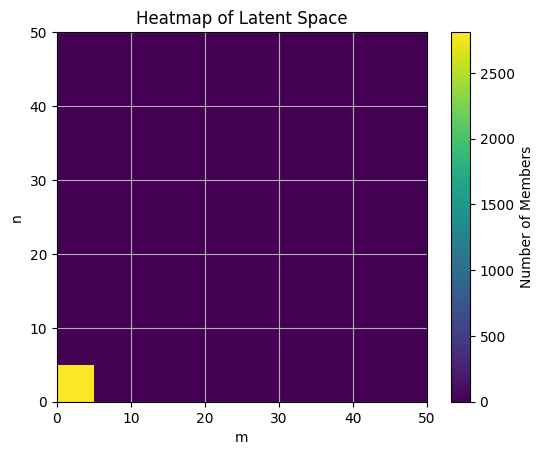

In [42]:
plot_som_grid(method2_map_dtw, 50,50, bin_length=10)

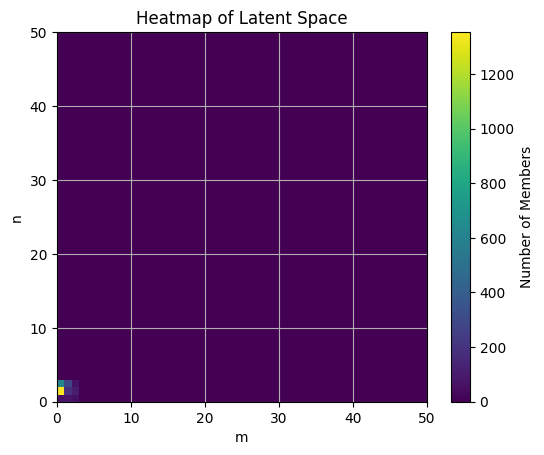

In [44]:
plot_som_grid(method2_map_dtw, 50,50, bin_length=50)